In [1]:
# 1.加载原始拓扑
import json
import networkx as nx
import matplotlib.pyplot as plt

# 读取JSON文件
def load_json_topology(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

# 解析JSON数据并构建图
def build_graph_from_json(data):
    G = nx.Graph()  # 或者使用 nx.DiGraph() 如果是需要有向图
    
    # 添加节点
    for node_id, node_info in data['nodes'].items():
        #不读取主机
        if 'h' not in node_id:
            G.add_node(node_id, **node_info)
    
    # 添加边
    for link_info in data['links']:
        from_id = link_info['from']
        to_id = link_info['to']
        if G.has_node(from_id) and G.has_node(to_id):
            #不读取重复的边
            if not G.has_edge(from_id, to_id):
                G.add_edge(from_id, to_id, **link_info)
    
    return G

# 指定文件路径
file_path = '..\\topo_zone\mini-topologies-json\Aarnet.json'

# 加载JSON文件
data = load_json_topology(file_path)

# 构建图
G = build_graph_from_json(data)

# 输出图的信息
print("Nodes of graph: ", G.nodes(data=True))
print("Edges of graph: ", G.edges(data=True))


Nodes of graph:  [('s0', {'id': 's0', 'label': 'Sydney10', 'dpid': '1', 'node_type': 'switch', 'longitude': '151.20732', 'latitude': '-33.86785', 'ip': ' 10.0.8.1'}), ('s1', {'id': 's1', 'label': 'Brisbane21', 'dpid': '2', 'node_type': 'switch', 'longitude': '153.02809', 'latitude': '-27.46794', 'ip': ' 10.0.8.2'}), ('s2', {'id': 's2', 'label': 'Canberra12', 'dpid': '3', 'node_type': 'switch', 'longitude': '149.12807', 'latitude': '-35.28346', 'ip': ' 10.0.8.3'}), ('s3', {'id': 's3', 'label': 'Sydney23', 'dpid': '4', 'node_type': 'switch', 'longitude': '151.20732', 'latitude': '-33.86785', 'ip': ' 10.0.8.4'}), ('s4', {'id': 's4', 'label': 'Townsville4', 'dpid': '5', 'node_type': 'switch', 'longitude': '146.8', 'latitude': '-19.25', 'ip': ' 10.0.8.5'}), ('s5', {'id': 's5', 'label': 'Cairns5', 'dpid': '6', 'node_type': 'switch', 'longitude': '145.76667', 'latitude': '-16.91667', 'ip': ' 10.0.8.6'}), ('s6', {'id': 's6', 'label': 'Brisbane16', 'dpid': '7', 'node_type': 'switch', 'longitude

In [2]:
# 2.处理介数中心性 并生成恶意流分布
import json
import networkx as nx
import numpy as np
def load_topology_from_json(file_path):
    with open(file_path, 'r') as file:
        topo_data = json.load(file)
    return topo_data

def create_networkx_graph(topo_data):
    G = nx.Graph()
    # Add nodes
    for node_id, node_info in topo_data['nodes'].items():
        #不读取主机
        if 'h' not in node_id:
            G.add_node(node_id, **node_info)
    # Add links
    for link in topo_data['links']:
        from_id = link['from']
        to_id = link['to']
        if G.has_node(from_id) and G.has_node(to_id):
            #不读取重复的边
            if not G.has_edge(from_id, to_id):
                G.add_edge(from_id,to_id, bandwidth=link['bandwidth'], latency=link['latency'])
    return G

def calculate_betweenness_centrality(G):
    betweenness = nx.betweenness_centrality(G)
    return betweenness

def save_new_topo_with_betweenness(topo_data, betweenness, new_file_path):
    # 生成恶意流分布数组
    #malicious_flows_data = np.random.gamma(shape=1, scale=10, size=len(betweenness.values()))
    malicious_flows_data = np.random.normal(loc=5, scale=4, size=len(betweenness.values()))
    malicious_flows_data += abs(malicious_flows_data.min()) + 1 #保证生成数据为正
    #归一化
    malicious_flows_data = malicious_flows_data/np.sum(list(malicious_flows_data))
    costs = { node_id:np.exp(bc*10) for node_id, bc in betweenness.items()} #成本随bc成指数增长
    for i,(node_id, bc) in enumerate(betweenness.items()):
        if 'betweenness' not in topo_data['nodes'][node_id]:
            bc = round(bc,4) #保留4位小数
            topo_data['nodes'][node_id]['betweenness'] = bc
            topo_data['nodes'][node_id]['malicious_flows'] = round(malicious_flows_data[i],4)
            topo_data['nodes'][node_id]['costs'] = round(costs[node_id]/np.sum(list(costs.values())),4) #成本归一化
            topo_data['nodes'][node_id]['filtering_capacities'] = round(3*bc,4) #过滤能力与bc一致
    with open(new_file_path, 'w') as file:
        json.dump(topo_data, file, indent=4)


# Load topology from JSON
topo_data = load_topology_from_json('..\\topo_zone\mini-topologies-json\Aarnet.json')
# Create NetworkX graph
G = create_networkx_graph(topo_data)
# Calculate betweenness centrality
betweenness = calculate_betweenness_centrality(G)
# Save new topology with betweenness centrality
save_new_topo_with_betweenness(topo_data, betweenness, '..\\topo_zone\process_topologies\Aarnet.json')


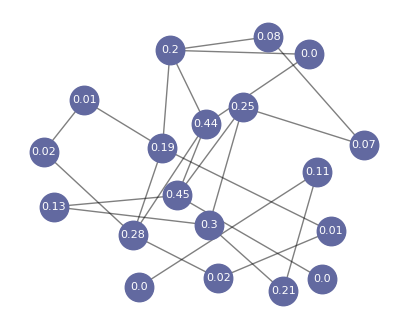

In [3]:
import matplotlib.pyplot as plt
def draw_graph(G,betweenness=None):
    # 绘制图形
    plt.figure(figsize=(5, 4))
    # 使用 spring_layout 生成节点位置布局
    pos = nx.spring_layout(G,k=1.5)
    # 绘制节点
    nx.draw_networkx_nodes(G, pos, node_size=420,node_color="#6269A0")
    # 绘制边
    nx.draw_networkx_edges(G, pos, width=1.0, alpha=0.5)
    # 绘制标签
    # 绘制带有 betweenness 属性的标签
    if betweenness is not None:
        labels = {}
        for id,node in G.nodes(data=True):
            labels[node['id']]=round(betweenness[node['id']],2)
        nx.draw_networkx_labels(G, pos,labels=labels, font_size=8, font_color="w",font_family="sans-serif")
    else:
        nx.draw_networkx_labels(G, pos, font_size=8, font_color="w",font_family="sans-serif")
    # 显示图
    plt.axis('off')
    plt.show()
#draw graph
draw_graph(G,betweenness)

In [5]:
import json
import random
import ipaddress
import networkx as nx

def generate_random_ips(network, count):
    # 生成指定数量的随机IP地址
    random_ips = set()  # 使用set避免重复
    while len(random_ips) < count:
        # 随机选择网络中的一个主机位
        host = random.randint(1, 2**network.prefixlen - 2)  # 减2是因为排除网络地址和广播地址
        ip_int = int(network.network_address) + host
        random_ips.add(str(ipaddress.IPv4Address(ip_int)))
    return list(random_ips)

def generate_hosts(base_ip, num_hosts, prefix_length=16):
    hosts = []
    for i in range(num_hosts):
        # 构建网络前缀
        network_prefix = f"{base_ip}/{prefix_length}"
        # 创建IPv4Network对象
        network = ipaddress.IPv4Network(network_prefix, strict=False)
        # 将网络对象添加到列表中
        hosts.append(network)
        # 增加基础IP地址以便生成下一个网络
        base_ip = str(ipaddress.IPv4Address(ipaddress.IPv4Address(base_ip) + 2**(32-network.prefixlen)))
    return hosts

def generate_nodes(base_ip="10.0.0.0", num_nodes=100, prefix_length=16, num_ips_per_network=100):
    # 生成网络域
    hosts = generate_hosts(base_ip, num_nodes, prefix_length)
    nodes = []
    for network in hosts:
        node = {
            'id': str(len(nodes) + 1),
            'network_prefix': str(network.network_address),
            'netmask': str(network.netmask),
            'ip': str(network.network_address + 1),  # 设置第一个可用IP作为默认IP
            'hosts': generate_random_ips(network, num_ips_per_network)
        }
        nodes.append(node)
    return nodes

def replace_topo_data(topo_data, base_ip="10.0.0.0", num_nodes=None, prefix_length=16, num_ips_per_network=100):
    if num_nodes is None:
        num_nodes = len(topo_data['nodes'])
    
    # 生成新的节点
    generated_nodes = generate_nodes(base_ip=base_ip, num_nodes=num_nodes, prefix_length=prefix_length, num_ips_per_network=num_ips_per_network)
   
    # 更新原始拓扑数据
    for idx, node in enumerate(generated_nodes):
        node_id = f"s{idx}"
        topo_data['nodes'][node_id]["ip"] = node['ip']
        topo_data['nodes'][node_id]["hosts"] = node['hosts']
   
    return topo_data

def calculate_all_pairs_shortest_paths(topo):
    """
    根据给定的拓扑结构计算所有节点之间的最短路径，并以 IP 地址形式存储路径。
    
    :param topo: 包含节点和链接信息的拓扑结构字典
    :return: 包含所有节点之间最短路径的字典
    """
    # 提取所有节点IP
    nodes = topo['nodes']
    node_ips = [node['ip'] for id,node in nodes.items()]
    
    # 初始化距离矩阵和路径矩阵
    distance_matrix = {}
    path_matrix = {}
    for ip in node_ips:
        distance_matrix[ip] = {}
        path_matrix[ip] = {}
        for other_ip in node_ips:
            if ip == other_ip:
                distance_matrix[ip][other_ip] = 0
                path_matrix[ip][other_ip] = [ip]
            else:
                distance_matrix[ip][other_ip] = float('inf')
                path_matrix[ip][other_ip] = []

    # 根据链接填充距离矩阵
    links = topo['links']
    for link in links:
        #不考虑延迟所有链路距离为1
        ip_from = nodes[link['from']]['ip']
        ip_to =nodes[link['to']]['ip']
        distance_matrix[ip_from][ip_to] = 1
        distance_matrix[ip_to][ip_from] = 1
        path_matrix[ip_from][ip_to] = [ip_from, ip_to]
        path_matrix[ip_to][ip_from] = [ip_to,ip_from]

    # Floyd-Warshall 算法
    for k in node_ips:
        for i in node_ips:
            for j in node_ips:
                if distance_matrix[i][j] > distance_matrix[i][k] + distance_matrix[k][j]:
                    distance_matrix[i][j] = distance_matrix[i][k] + distance_matrix[k][j]
                    path_matrix[i][j] = path_matrix[i][k] + path_matrix[k][j][1:]

    # 更新 topo 的 shortest_paths 字段
    topo['shortest_paths'] = path_matrix
    
    return topo

def save_new_topo(topo_data, new_file_path):
    with open(new_file_path, 'w') as file:
        json.dump(topo_data, file, indent=4)


# 假设这是原始拓扑数据的一部分
topo_data = {}
with open('..\\topo_zone\process_topologies\Aarnet.json', 'r') as file:
    topo_data = json.load(file)
    
# 移除原有的Host节点
topo_data['nodes'] = {node_id: node for node_id, node in topo_data['nodes'].items() if node_id.startswith('s')}
#移除主机链路
topo_data['links'] = [link for link in topo_data['links'] if link['from'].startswith('s') and link['to'].startswith('s')]
# 替换拓扑数据(每个AS生成2000台主机)
updated_topo_data = replace_topo_data(topo_data,
                                       base_ip="10.0.0.0",
                                       num_nodes=len(topo_data['nodes']),
                                       prefix_length=16, 
                                       num_ips_per_network=2000)

# 使用NetworkX计算最短路径
updated_topo_data= calculate_all_pairs_shortest_paths(updated_topo_data)

# 保存新拓扑
save_new_topo(updated_topo_data, '..\\topo_zone\process_topologies\\Aarnet_topo.json')